# High school homicide analysis

By [Iris Lee](http://www.twitter.com/@irisslee)

The Los Angeles Times [Homicide Report](https://homicide.latimes.com) conducted an analysis of killings near public high schools and found that a small number of high schools are surrounded by extremely high number of homicides. Of the 262 schools included in the analysis, there are 15 schools which has been near more than 50 homicides in the last five years. That work resulted in the February 27th story ["What it's like to go to school when dozens have been killed nearby"](www.latimes.com/projects/la-me-edu-school-safety-deaths-nearby/).

 

### Configuration

Set environment variables for all notebooks.

In [1]:
import os, warnings
import pandas as pd
import altair as alt
import geopandas as gpd

In [2]:
warnings.filterwarnings('ignore')
alt.renderers.enable('notebook')
pd.set_option('display.max_columns', 500)

In [3]:
base_dir = os.getcwd()

In [4]:
input_dir = os.path.join(base_dir, 'input')
output_dir = os.path.join(base_dir, 'output')

In [5]:
%%capture
os.path.exists(input_dir) or os.mkdir(input_dir)
os.path.exists(output_dir) or os.mkdir(output_dir)

In [6]:
%%capture
%store input_dir
%store output_dir

## Data collection

### Download LA high schools

The [California Departmen of Education](cde.ca.gov) provides list of schools every year

In [7]:
%run src/download-la-highschools.ipynb

### Clean LA high schools

Schools that moved locations in the last five years were excluded from the analysis. Excluded schools were indentified by comparing historic school location data from [National Center for Education Statistics](nces.ed.gov) to the most current list provided by CDE. 

In [8]:
%run src/clean-la-highschools.ipynb

In [9]:
%run src/download-nces-schools.ipynb

In [10]:
%run src/clean-nces-schools.ipynb

In [11]:
%run src/find-changing-addresses.ipynb

In [12]:
%run src/remove-changing-addresses.ipynb

In [13]:
%run src/finalize-la-highschools.ipynb

### Download Homicides

Retrieves homicide list from The Times' unpublished API. This step has been withheld from the notebook to maintain our site's security.

In [14]:
%run src/download-homicides.ipynb

### Clean homicides

Creates a simplified homicides file that includes only the records needed for the analysis. 

In [15]:
%run src/transform-homicides.ipynb

### Spatial join

Identify homicides that occured inside school buffers through spatial join.

Read in GeoDataFrames

In [7]:
homicides = gpd.read_file(os.path.join(output_dir, 'homicides-five-years.shp'))

In [8]:
schools = gpd.read_file(os.path.join(output_dir, 'school-buffers.shp'))

Find all homicides that happened within one mile of a qualified LA County high school.

In [9]:
homicides_near_hs = gpd.sjoin(homicides, schools, op='within')

Remove homicides that occured before the nearby school was open

First, convert school open date column and person death date colum to datetime type

In [10]:
homicides_near_hs[['open_date', 'death_date']] = homicides_near_hs[['open_date', 'death_date']].apply(pd.to_datetime)

In [11]:
valid_homicides_near_hs = homicides_near_hs[homicides_near_hs.death_date >= homicides_near_hs.open_date]

There may be duplicate homicides if they are linked to more than one school

In [12]:
len(valid_homicides_near_hs)

4055

In [13]:
valid_homicides_near_hs.ID.nunique()

2215

### Analysis

Create a new dataframe that groups the schools with number of homicides nearby 

In [14]:
homicides_by_school = valid_homicides_near_hs.groupby([
    'cds_code', 
    'name'
]).size().rename('homicide_count').reset_index()

In [15]:
homicides_by_school.head()

,cds_code,name,homicide_count
0,19642121930056,Cerritos High,2
1,19642121930361,Artesia High,7
2,19642121933159,Gahr (Richard) High,8
3,19642460108407,Eastside High,1
4,19642461930213,Antelope Valley High,10


Schools without homicides would have been left out from the join. Identify schools without homicides

How many schools had no homicides nearby?

In [16]:
zero_homicides = schools[~schools.cds_code.isin(valid_homicides_near_hs.cds_code)][['cds_code','name']]

In [17]:
len(zero_homicides)

33

Add those schools into the ranking so it is complete.

In [18]:
complete_homicides_by_school = pd.concat([homicides_by_school, zero_homicides]).fillna(0)

Make sure that worked.

In [19]:
assert len(complete_homicides_by_school) == len(schools)

What is the distribution of schools?

In [20]:
complete_homicides_by_school.describe().reset_index()

,index,homicide_count
0,count,295.000000
1,mean,13.745763
2,std,17.190404
3,min,0.000000
4,25%,2.000000
5,50%,6.000000
6,75%,20.500000
7,max,105.000000


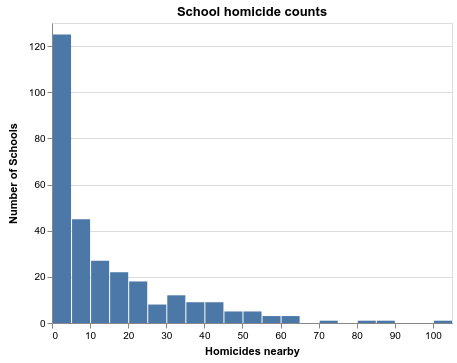

In [21]:
alt.Chart(complete_homicides_by_school, title="School homicide counts").mark_bar().encode(
    x=alt.X('homicide_count:Q', bin=alt.Bin(step=5), axis=alt.Axis(title="Homicides nearby")),
    y=alt.Y('count()', axis=alt.Axis(title='Number of Schools'))
)

How many schools have a homicide nearby?

In [31]:
len(complete_homicides_by_school[complete_homicides_by_school.homicide_count > 0])

262

What percent schools had homicides nearby?

In [32]:
"{0:.0%}".format(
    len(complete_homicides_by_school[complete_homicides_by_school.homicide_count > 0]) / 
    float(len(complete_homicides_by_school)))

'89%'

What percent of homicides occured near schools?

In [33]:
"{0:.0%}".format(valid_homicides_near_hs.ID.nunique() / float(len(homicides)))

'69%'

How many schools 50 or more homicides nearby?

In [34]:
over_50 = homicides_by_school[homicides_by_school.homicide_count >= 50]

In [35]:
len(over_50)

15

In [43]:
over_50.sort_values('homicide_count', ascending = False)

,cds_code,name,homicide_count
127,19647330126573,Academy for Multilingual Arts and Science at M...,105
78,19647330108894,Alliance Judy Ivie Burton Technology Academy High,85
161,19647331933118,John C. Fremont Senior High,81
124,19647330126508,Augustus F. Hawkins High C Responsible Indigen...,72
58,19647251936947,Polytechnic High,63
240,19734370115725,Lifeline Education Charter,63
101,19647330118588,Alain Leroy Locke College Preparatory Academy,62
84,19647330111492,Alliance Patti And Peter Neuwirth Leadership A...,59
117,19647330124479,Dr. Maya Angelou Community High,59
73,19647330106849,Animo Pat Brown,55


What percentage of total homicides occured around the "over 50" schools?

In [37]:
over_50_schools_homicides = valid_homicides_near_hs[valid_homicides_near_hs.cds_code.isin(over_50.cds_code.tolist())]

In [38]:
"{0:.0%}".format(over_50_schools_homicides.ID.nunique()/float(len(homicides)))

'20%'

Write out the school ranking as a shapefile

In [39]:
valid_homicides_near_hs[['open_date', 'death_date']] = valid_homicides_near_hs[['open_date', 'death_date']].astype(str)

In [40]:
valid_homicides_near_hs = gpd.read_file(os.path.join(output_dir, 'homicides-near-hs.shp'))